In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
# read in data
visitor_log = pd.read_csv("visitor_log.csv", parse_dates=[0])
visitor_log["unique_visitor"] = visitor_log[['name', 'dob']].apply(lambda x: '_'.join(x), axis=1)
visitor_log.drop(columns=['name', 'dob'], axis=1, inplace=True)
print(visitor_log.head())
print("================================================")

theft_log = pd.read_csv("theft_log.csv", header=None, names=["visit_date"],parse_dates=[0])
theft_log['indicator'] = 1
theft_log = theft_log.iloc[2:-1] # take care
print(theft_log.head())

  visit_date              unique_visitor
0 2016-06-16  Samuel Casanova_1990-03-12
1 2016-06-16    Gerald Orozco_1990-10-05
2 2016-06-16     Sharon Davis_1990-10-18
3 2016-06-16  Spencer Spencer_1991-10-13
4 2016-06-16   Steven Estevez_1992-01-13
  visit_date  indicator
2 2016-12-25          1
3 2016-12-22          1
4 2016-12-19          1
5 2016-12-18          1
6 2016-12-15          1


In [3]:
# merge two files by date
merged_log = visitor_log.merge(theft_log, how='left', on='visit_date')
merged_log.fillna(0, inplace=True)
print(merged_log.head())

  visit_date              unique_visitor  indicator
0 2016-06-16  Samuel Casanova_1990-03-12        0.0
1 2016-06-16    Gerald Orozco_1990-10-05        0.0
2 2016-06-16     Sharon Davis_1990-10-18        0.0
3 2016-06-16  Spencer Spencer_1991-10-13        0.0
4 2016-06-16   Steven Estevez_1992-01-13        0.0


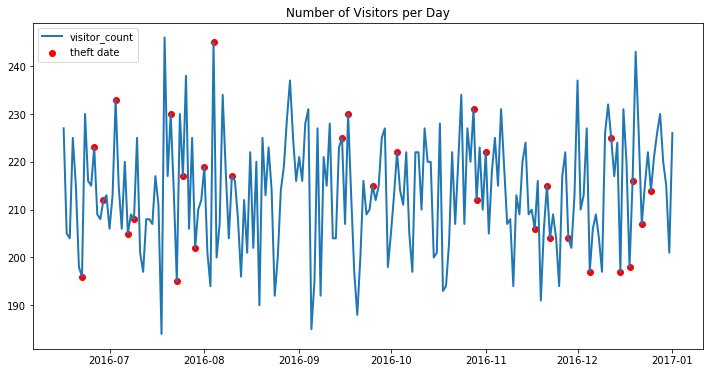

In [5]:
# calculate number of visitors on each day
stat_table = merged_log.groupby('visit_date')\
             .agg({'unique_visitor':'count', 'indicator': 'mean'})\
             .reset_index()\
             .rename(columns={'unique_visitor':'visitor_count'})

theft_stat_table = stat_table[stat_table.indicator==1]

# plot figure
plt.figure(figsize=(12,6))
plt.plot(stat_table['visit_date'], stat_table['visitor_count'], linewidth=2)
plt.scatter(theft_stat_table['visit_date'], theft_stat_table['visitor_count'], color='r',label = 'theft date') 
plt.legend()
plt.title("Number of Visitors per Day")
plt.show() 

#### Step1 - Find candidate thieves
we assume he/she is NOT a candidate thief if he/she does not visit the club in any theft date, otherwise, he/she is a candidate thief.

In [4]:
# get candidate thieves' name 
theft_table = merged_log[merged_log.indicator==1.]
unique_candidate_names = list(set(list(theft_table.unique_visitor)))

# creat a dictionary with visiting date per each candidate theft
info_dict = dict()
for index, row in merged_log.iterrows():
    _name = row.unique_visitor
    if _name not in unique_candidate_names:
        continue
    else:     
        if _name not in info_dict:
            info_dict[_name]={}
            info_dict[_name]["visit_dates"], info_dict[_name]["theft_dates"]=[],[]
            
        if row["indicator"] == 1.:
            info_dict[_name]["theft_dates"].append(row.visit_date)
            
        info_dict[_name]["visit_dates"].append(row.visit_date)  

print("Number of candidate thieves: {}".format(len(info_dict)))

Number of candidate thieves: 904


#### Step2 - Find most suspicious ones among the candidates

#### Hypothesis of thief behaviour pattern
Thieves might be visiting the club frequently before a conducting a theft (to check theft condition, etc.), after a successful theft, he/she might not visit the club for a period for safety or move to other clubs. Conversely, normal customers might not visit the exact same club frequently in a short period, so the visiting frequency of normal customers should be more uniformly distributed than that of thieves. 

#### Algorithm
For a candidate thief, we extract his/her visit dates. Among his/her visit dates, there should at least one date is recorded as theft date. For every theft date of him/her, we count:
- A = number of visits before the theft date within 5 natural days
- B = number of visits after the theft date within 5 natural days
- if A >= 4 and B == 0: we say he/she is a thief
The idea is within 5 natural days before a theft, if he/she visits the club at least 4 times, and does not visit the club in the next 5 narual days after the theft, he/she is a theft.

We also consider for a theft: theft_percentage = number_of_theft_in_his_visit_dates / his_total_number_of_visites, as the ranking indicator.

In [15]:
import numpy as np

threshold_days = 5

theft_names = []; thieves = {}
data_for_cluster = []; data_labels = []

for key in info_dict:
    visit_dates = info_dict[key]["visit_dates"]
    theft_dates = info_dict[key]["theft_dates"]

    # score1: theft_percentage
    theft_percentage = np.round(float(len(theft_dates)) / len(visit_dates),2)

    # score2: num_days before/after theft_days within threshold days
    _scores = []
    for theft_date in theft_dates:
        days_before_theft = 0
        pos = visit_dates.index(theft_date)-1
        while pos >= 0 and (theft_date - visit_dates[pos]).days<=threshold_days:
            days_before_theft += 1
            pos -= 1

        days_after_theft = 0
        pos = visit_dates.index(theft_date)+1
        while pos <= len(visit_dates)-1 and (visit_dates[pos] - theft_date).days<=threshold_days:
            days_after_theft += 1
            pos += 1
        
        if days_after_theft == 0 and days_before_theft - days_after_theft >= 4:
            theft_names.append(key); thieves[key] = theft_percentage
        
        data_for_cluster.append([theft_percentage, days_before_theft, days_after_theft])
        data_labels.append(key)

print("Most Suspicious Persons:")
for m in theft_names:
    print(m)

Most Suspicious Persons:
John Bona_1994-03-22
Laura Sotelo_1994-04-06
Hazel Jefferies_1995-12-14
Justin Achenbach_1996-06-29
Felicia Preece_1996-07-09
Ruby Pace_1996-07-24
Cheryl Harris_1996-07-30
Cheryl Harris_1996-07-30
Joseph Hirneise_1995-12-18
Joseph Hirneise_1995-12-18
Lisa Hazelwood_1996-06-14
Sheila Burch_1996-07-18
David Graves_1997-02-03
Katrina Beasley_1997-03-06
Etha Holt_1994-08-05
Byron Wafford_1995-05-21
Brad Friedman_1997-05-06
James Borders_1990-12-31
Eva Mulder_1997-05-28
Anna Morris_1995-02-15


Cheryl Harris and Joseph Hirneise should be the most probabe thevies because they appeared twice in the above recordings. Other people can be ranked by their theft_percentage.

In [16]:
import operator
thieves = sorted(thieves.items(), key=operator.itemgetter(1),reverse=True)
for item in thieves:
    if item != 'Cheryl Harris_1996-07-30' or 'Joseph Hirneise_1995-12-18':
        print(item)

('Hazel Jefferies_1995-12-14', 0.23)
('Etha Holt_1994-08-05', 0.23)
('James Borders_1990-12-31', 0.2)
('Laura Sotelo_1994-04-06', 0.19)
('Byron Wafford_1995-05-21', 0.19)
('Anna Morris_1995-02-15', 0.19)
('Ruby Pace_1996-07-24', 0.18)
('Eva Mulder_1997-05-28', 0.17)
('Cheryl Harris_1996-07-30', 0.16)
('Lisa Hazelwood_1996-06-14', 0.16)
('Justin Achenbach_1996-06-29', 0.15)
('David Graves_1997-02-03', 0.15)
('Katrina Beasley_1997-03-06', 0.15)
('Felicia Preece_1996-07-09', 0.14)
('Joseph Hirneise_1995-12-18', 0.13)
('Brad Friedman_1997-05-06', 0.12)
('John Bona_1994-03-22', 0.1)
('Sheila Burch_1996-07-18', 0.1)


#### Step3 - try to cluster candidates into two groups. The assumption is that there should be one group with very small number of people and they are more likely to be thivies. However, the results indicate that the assumption is incorrect.

In [25]:
# K-means to cluster candidate thieves into two groups
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000).fit(data_for_cluster)
group_labels = list(kmeans.labels_)
print("Number of people in Group 1: {}".format(group_labels.count(0)))
print("Number of people in Group 2: {}".format(group_labels.count(1)))

Number of people in Group 1: 3008
Number of people in Group 2: 3634
